The following example runs over a dataset of aerobic actions recorded from subjects "using the Inertial Measurement Unit (IMU) on an Apple iPhone 4 smartphone. The IMU includes a 3D accelerometer, gyroscope, and magnetometer*. Each sample was taken at 60Hz, and manually trimmed to 500 samples (8.33s) to eliminate starting and stopping movements. iPhone is always clipped to the belt on the right hand side."

Each file contains 500 rows, each row with the following information:
Acc_x,Acc_y,Acc_z,Gyr_x,Gyr_y,Gyr_z,Mag_x,Mag_y,Mag_z

Each sensor has 3 channels.

You may find the dataset and revelant information about the publication 'Corey McCall, Kishore Reddy and Mubarak Shah, Macro-Class Selection for Hierarchical K-NN Classification of Inertial Sensor Data, Second International Conference on Pervasive and Embedded Computing and Communication Systems, PECCS 2012, February 24-26, 2012, Rome, Italy.' at: http://crcv.ucf.edu/data/UCF-iPhone.php

In [1]:
from itertools import chain
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from os import listdir
import time
from model import mogp_model

The following functions transform the dataset info into a more readily usable format, for multi-output regression. Note that the original files only contain the y-axis information, in increasing time order.

In [2]:
#Since the class of the activity is encoded in the filename we use this information to create numerical labels.
def conversion(label):
    if(label == 'bike'):
        return 0
    elif(label == 'climbing'):
        return 1
    elif(label == 'descending'):
        return 2
    elif(label == 'gymbike'):
        return 3
    elif(label == 'jumping'):
        return 4
    elif(label == 'running'):
        return 5
    elif(label == 'standing'):
        return 6
    elif(label == 'treadmill'):
        return 7
    elif(label == 'walking'):
        return 8
    
#For each one of the folders we get all the filenames within them.
def get_file_names(path):
    folder = path + 'S0%d'
    filenames = []
    for x in range(1,10):
        current_folder = folder % x
        onlyfiles = [current_folder + "/" + f for f in listdir(current_folder)]
        filenames.append(sorted(onlyfiles))
    return filenames

#Given the full_path (where the dataset resides in memory) we get all the filenames of all the dataset folders
#and generate (Y,label) lists.
def make_dataset(full_path):
    full_file_names = get_file_names(full_path)
    Y = []
    label_names = []
    label_numbers = []
    for folder_number in range(9):
        for filename in range(len(full_file_names[folder_number])):
            path = full_file_names[folder_number][filename]
            sample_data = np.genfromtxt(path, delimiter=',')
            Y.append(sample_data)
            label = path.split('/')
            label = label[len(label)-1].split('.')[0]
            label = label[0:len(label)-1]
            label_names.append(label)
            label_numbers.append(conversion(label))

    return Y, label_numbers, label_names

Now that we can access the y-axis information for each channel we have to create an x-axis counterpart to feed the model.

In [3]:
full_path = './data/HAR/Smartphone_Dataset/'
measurements, label_number, label_names = make_dataset(full_path)

#Since we're fitting curves, instead of performing a classification, we won't be using
#the class labels. We have to fabricate an X component to our y (the measurements).
#The measurements correspond to 9 channels (3 per sensor: accel, gyro, magnetometer) at
#a rate of 60hz. There's 500 measurements per channel, so the total time spanned is approx
#8.33s
X_list_bike = []
y_list_bike = []
X_list_climb = []
y_list_climb = []
#Note that measurements is a list containing all y-values for all channels for all experiments. So, by 
#accessing measurements[0] we are acquiring all the y-values for all 9 channels of experiment 0 which
#happens to be a bicycle ride.
measurements_for_one_bicycle_ride = measurements[0] #Remember that measurements is a list containing 
#Experiment 5 is an instance of climbing.
measurements_for_one_instance_of_climbing = measurements[5]

#The following loop allows us to pick any number of channels, without modifying channel order.
number_of_channels = 9
for index in range(number_of_channels):
    X_list_bike.append(np.array([x/60 for x in range(500)]))
    X_list_climb.append(np.array([x/60 for x in range(500)]))
    #We also remove the mean from the y-values to better approximate a mean=0 GP.
    y_list_bike.append(measurements_for_one_bicycle_ride[:,index]-measurements_for_one_bicycle_ride[:,index].mean())
    y_list_climb.append(measurements_for_one_instance_of_climbing[:,index]-measurements_for_one_instance_of_climbing[:,index].mean())

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -2905.507002
  Number of iterations: 1000
  Number of functions evaluations: 1119


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -2905.507002
  Number of iterations: 1000
  Number of functions evaluations: 1119


MAE over original data =  0.11739196500691566
{'GPR/kern/kernels/0/constant': array([ 8.53298051e+00, -2.65539814e-02,  4.68921176e-03, -2.81950124e-01,
        1.65324481e+00, -1.68966100e+00, -2.59185580e-01, -5.93902489e-03,
       -8.97304024e-02]), 'GPR/kern/kernels/0/delay': array([[  0.        ,   1.24794618,  -0.70682703,   0.75666556,
         -4.79393017,  16.18130071,   9.3292386 ,  -6.72033343,
        -11.62947327]]), 'GPR/kern/kernels/0/mean': array([[16.54173602,  7.48058585, 18.83981292,  1.30854781,  3.50612731,
         4.86547581,  4.6094834 ,  4.52962095, 35.25238278]]), 'GPR/kern/kernels/0/noise': array([0.00548941, 0.01053468, 0.0234282 , 0.00855735, 0.02131848,
       0.01435837, 0.13515562, 0.08221453, 0.02669407]), 'GPR/kern/kernels/0/phase': array([ 0.        ,  0.21146981, -0.42804702, -0.26671125, -1.33678816,
        3.21353295,  0.6643877 , -1.06715468, -0.50936999]), 'GPR/kern/kernels/0/variance': array([[1.00978185e-06, 7.22018182e-03, 1.00438755e-06, 3.

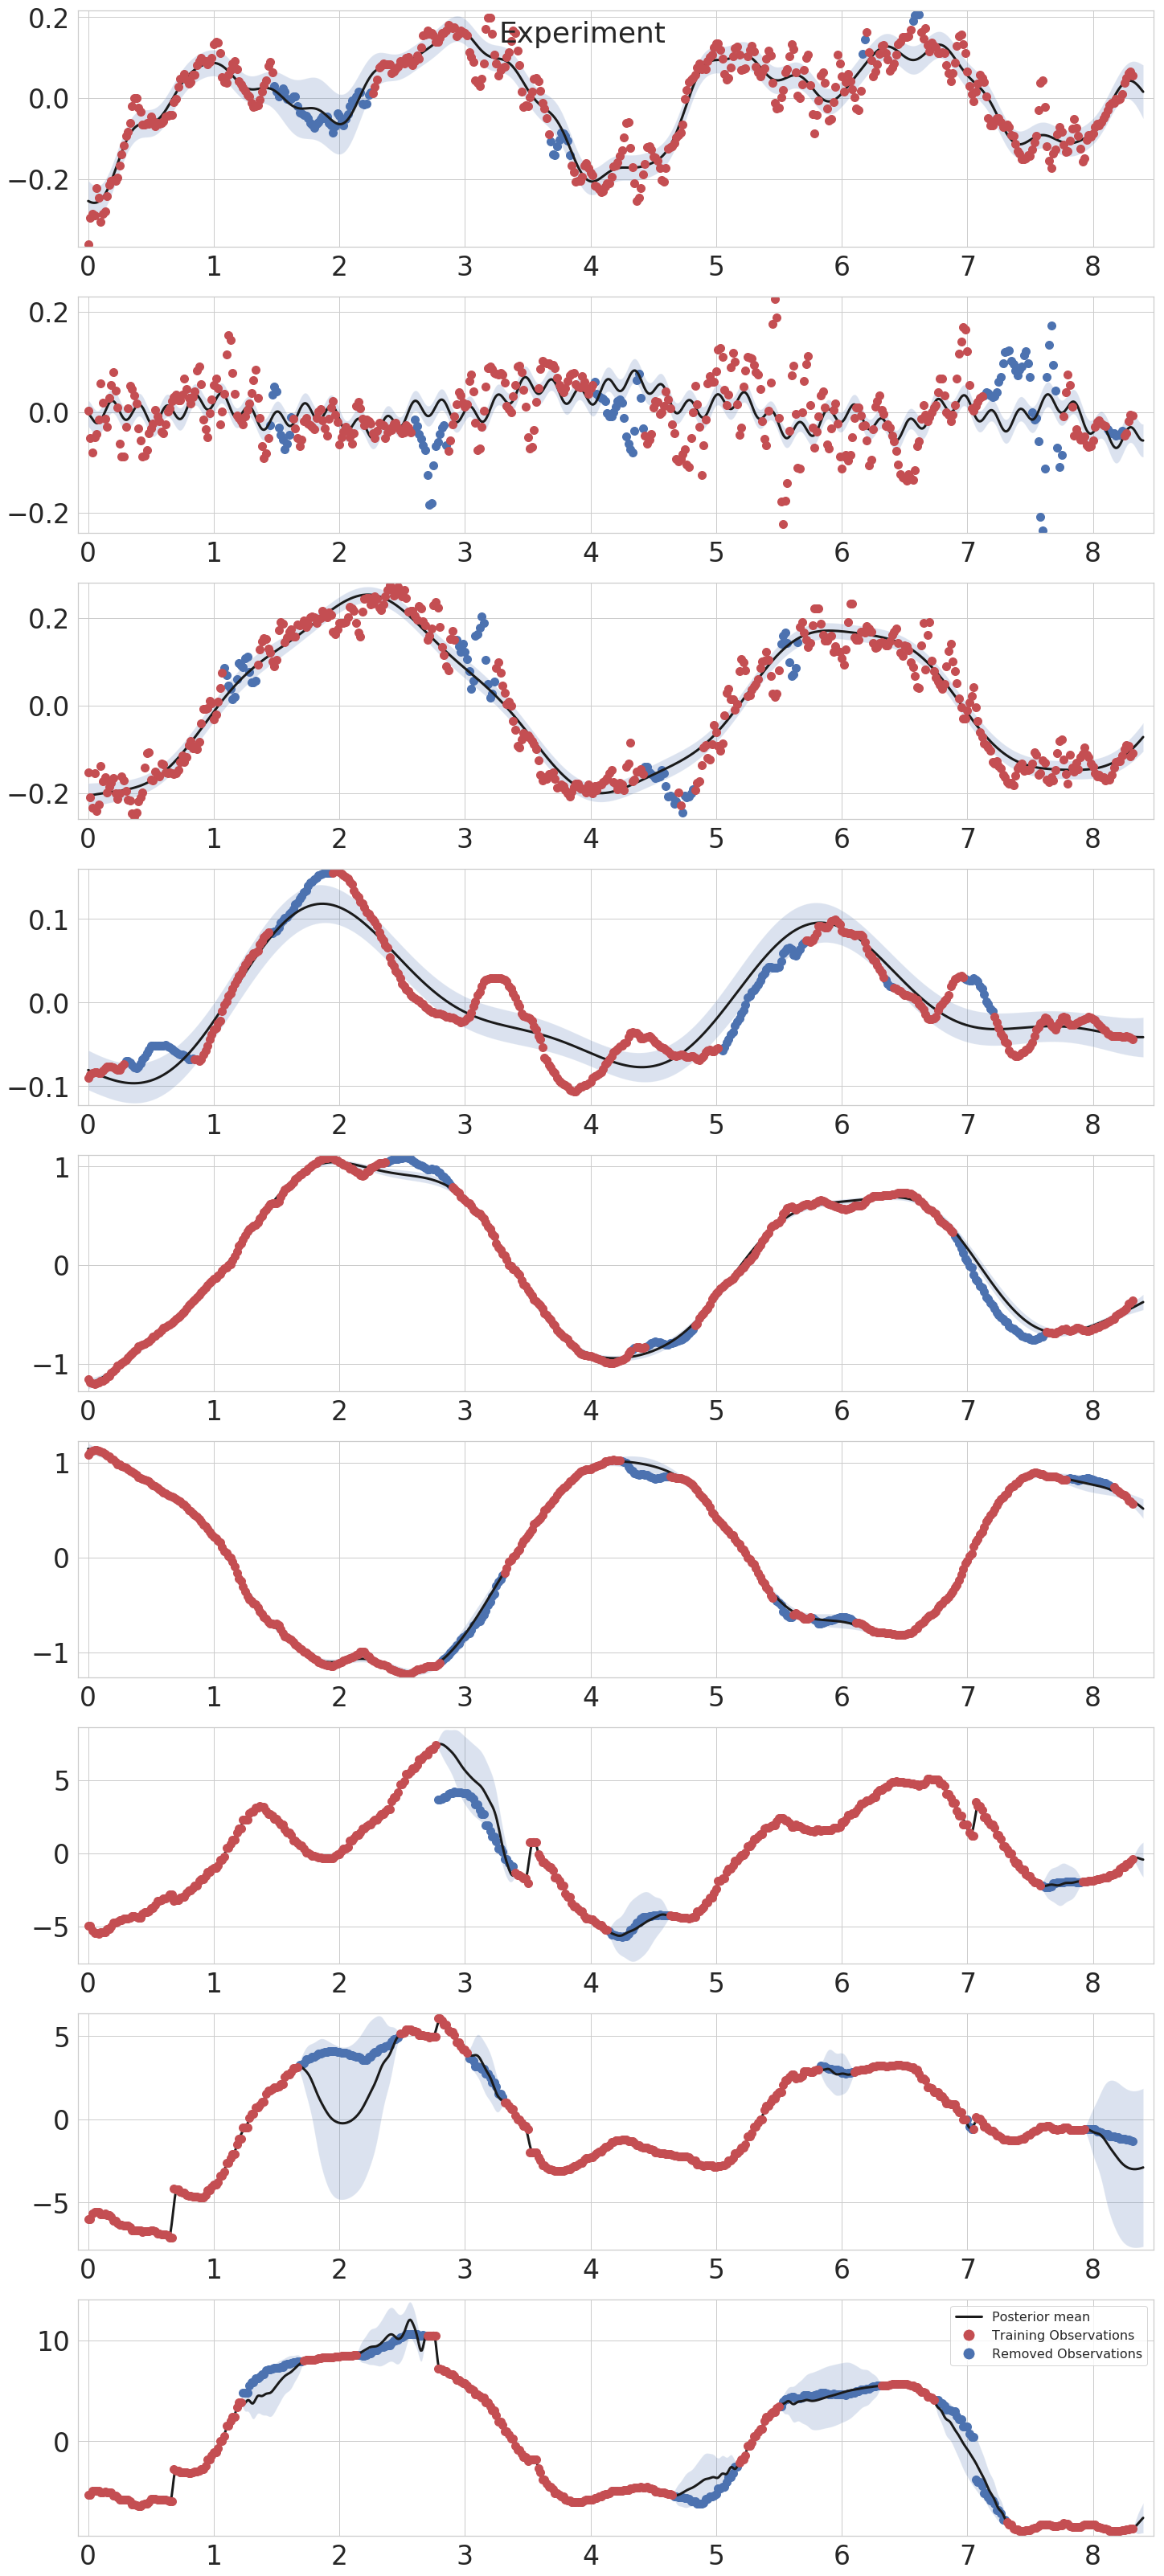

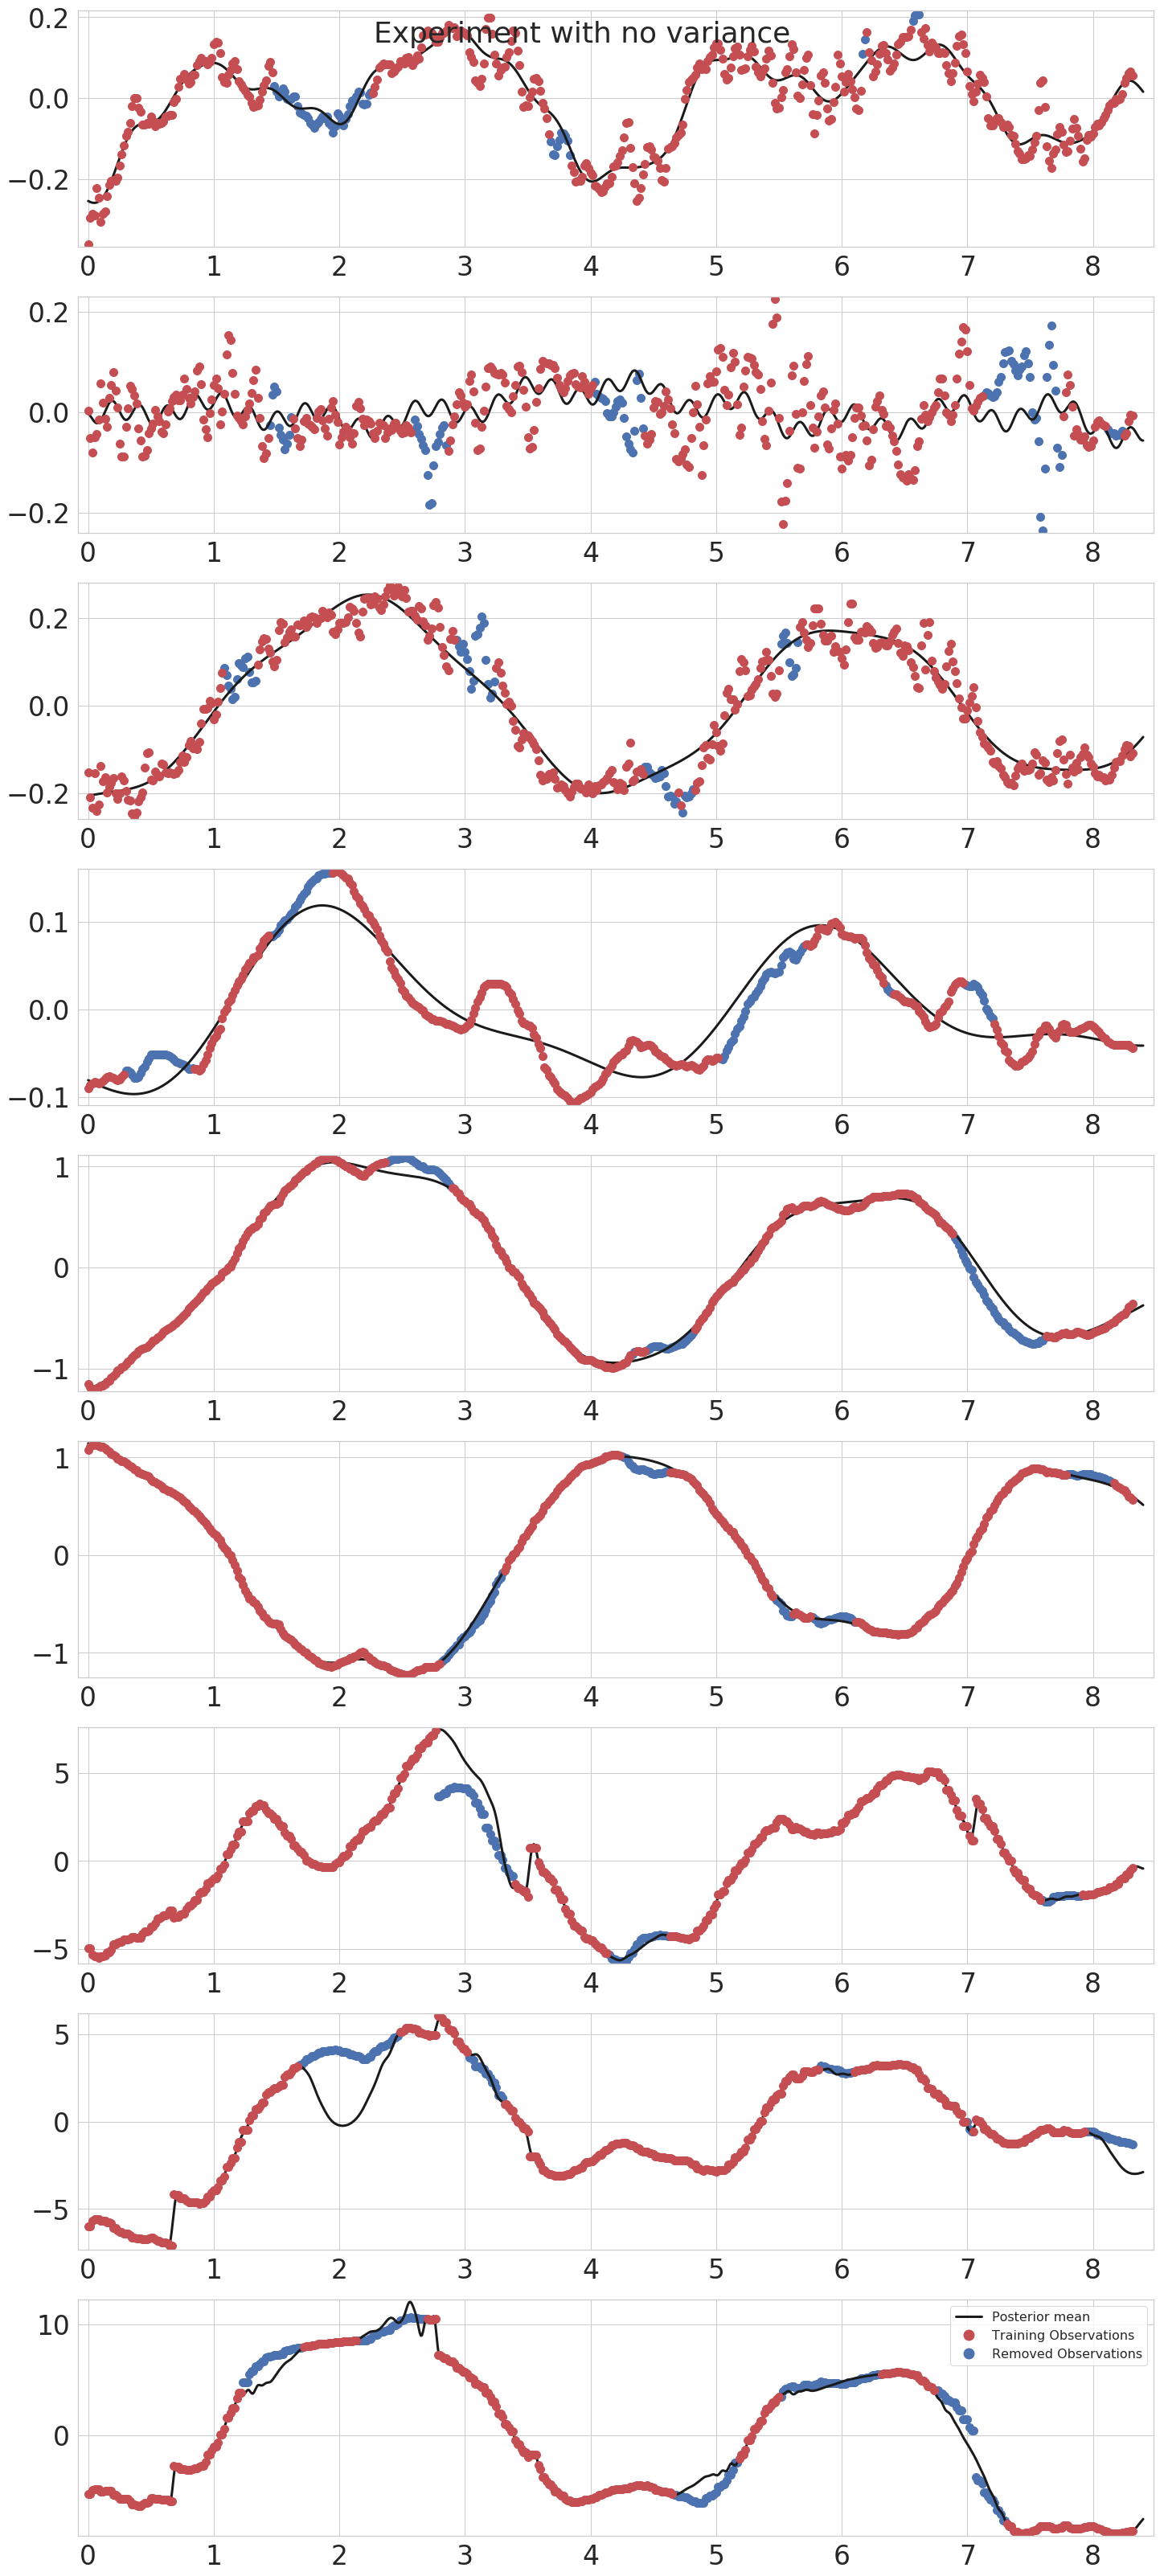

In [4]:
starting_time = time.time()
#We create the model, with 4 components and L-BFGS-B as the optimizer.
model = mogp_model(4, optimizer = 'L-BFGS-B')
#We'll consider the data pertaining the previously loaded climbing experiment (Experiment 5).
X_original, y_original = X_list_climb, y_list_climb

#To challenge the model in the reconstruction task we delete portions of the signals, randomly.
X_new, y_new, X_deleted, y_deleted = model.remove_slabs(X_list_climb, y_list_climb)

#We transform the data to the multi-output format.
X_input, Y_input = model.transform_lists_into_multioutput_format(X_new, y_new)
#For plotting purposes, we add the removed data. The last argument specifies the channel
#to which the removed data belongs. Since we're adding the deleted data in the same order
#as the original channels we just provide a range from 0 to number_of_channels.
model.add_extra_observations(X_deleted, y_deleted, [i for i in range(number_of_channels)])

#We add the training data (in multi-output format) to the model.
model.add_training_data(X_input,Y_input)

#We create testing data (a high resolution set of equally spaced points in an interval).
#First argument is the desired resolution (number of points between start and ending point), second argument are the desired channels to predict upon.
#Since our samples are taken at 60hz and there's 500 of them we define a range from 0s to 8.4s.
X_pred_new = model.predict_interval(1000, [x for x in range(number_of_channels)], start = [[0] for x in range(number_of_channels)],end = [[8.4] for x in range(number_of_channels)]) 

################## Build model and optimization #####################
#In the example notebook we showed that the model can be built with randomly chosen 
#starting parameters and then optimized to minimize NLL.
#In this case we will use one of the heuristics included in the toolbox.
#What this heuristic does, briefly, is:
#1) Find the most relevant frequencies in the training data using bayesian non-parametric spectral estimation.
#2) Use the found frequencies to build the model (all other parameters taken randomly, where appropriate).
#3) Optimize from there.
model.optimization_heuristic_zero(iterations=1000)
#####################################################################

#We can compute mean absolute error over some data. Note that, in this example,
#we'll be computing over all the original data points, which includes the removed
#observations not used to optimize the model.
mae = model.compute_mae(X_list_climb, y_list_climb)
print("MAE over original data = ", mae)

#Perform the prediction over the test data.
Y_pred, STD_pred = model.predict(X_pred_new)

#We inspect model parameters, after they have been optimized.
model.anchor_model()
print(model.read_trainables())

#We print the results of the prediction with and without variance.
model.make_plots("smartphone_climbing.png", var=True) #Variance is included in the plot.
model.make_plots("smartphone_climbing_no_var", var=False, title='Experiment with no variance') #Variance is not included.

#We can save the optimized model to memory.
model.save("smartphone_model_optimized")
end_time = time.time()
print("Total time for climbing: ", end_time-starting_time)

Due to the polling rate of the instrument the data points do not always lead to smooth curves (e.g: channel 6 near the 2.7s mark or channel 8 at 7s), which, of course, hinders the model's performance.

Let's see another example:

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4577.562568
  Number of iterations: 200
  Number of functions evaluations: 232


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4577.562568
  Number of iterations: 200
  Number of functions evaluations: 232


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4378.665097
  Number of iterations: 200
  Number of functions evaluations: 218


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4378.665097
  Number of iterations: 200
  Number of functions evaluations: 218


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4343.401783
  Number of iterations: 200
  Number of functions evaluations: 218


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4343.401783
  Number of iterations: 200
  Number of functions evaluations: 218


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4207.969945
  Number of iterations: 400
  Number of functions evaluations: 433


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4207.969945
  Number of iterations: 400
  Number of functions evaluations: 433


MAE over original data =  1.7719741811573775
{'GPR/kern/kernels/0/constant': array([-0.26789312,  0.09032946, -0.12497576,  0.04284505, -0.06865289,
       -0.00513372, -0.87807781, -0.38762284, -0.39545159]), 'GPR/kern/kernels/0/delay': array([[ 0.        ,  0.73226409, -0.02614663,  0.34918406,  0.08932279,
         0.02139696,  0.16424314, -0.64509884, -0.49491164]]), 'GPR/kern/kernels/0/mean': array([[25.58828947, 16.00153831, 16.67290388, 16.6603337 ,  1.20667989,
         4.34181715, -1.30890068,  3.09439568, 20.69669877]]), 'GPR/kern/kernels/0/noise': array([0.54937319, 0.07755771, 0.5214324 , 0.50777217, 0.5000978 ,
       0.53612684, 0.36536712, 0.43446894, 0.23342951]), 'GPR/kern/kernels/0/phase': array([ 0.        ,  0.04982683, -0.00463719,  0.02507961,  0.14171803,
       -0.0366992 ,  1.08482282, -1.20816755, -1.39753665]), 'GPR/kern/kernels/0/variance': array([[ 0.95547475,  0.19006084,  0.01280067,  0.0694928 ,  0.17893653,
         0.67224297,  4.13166925, 10.66556499,

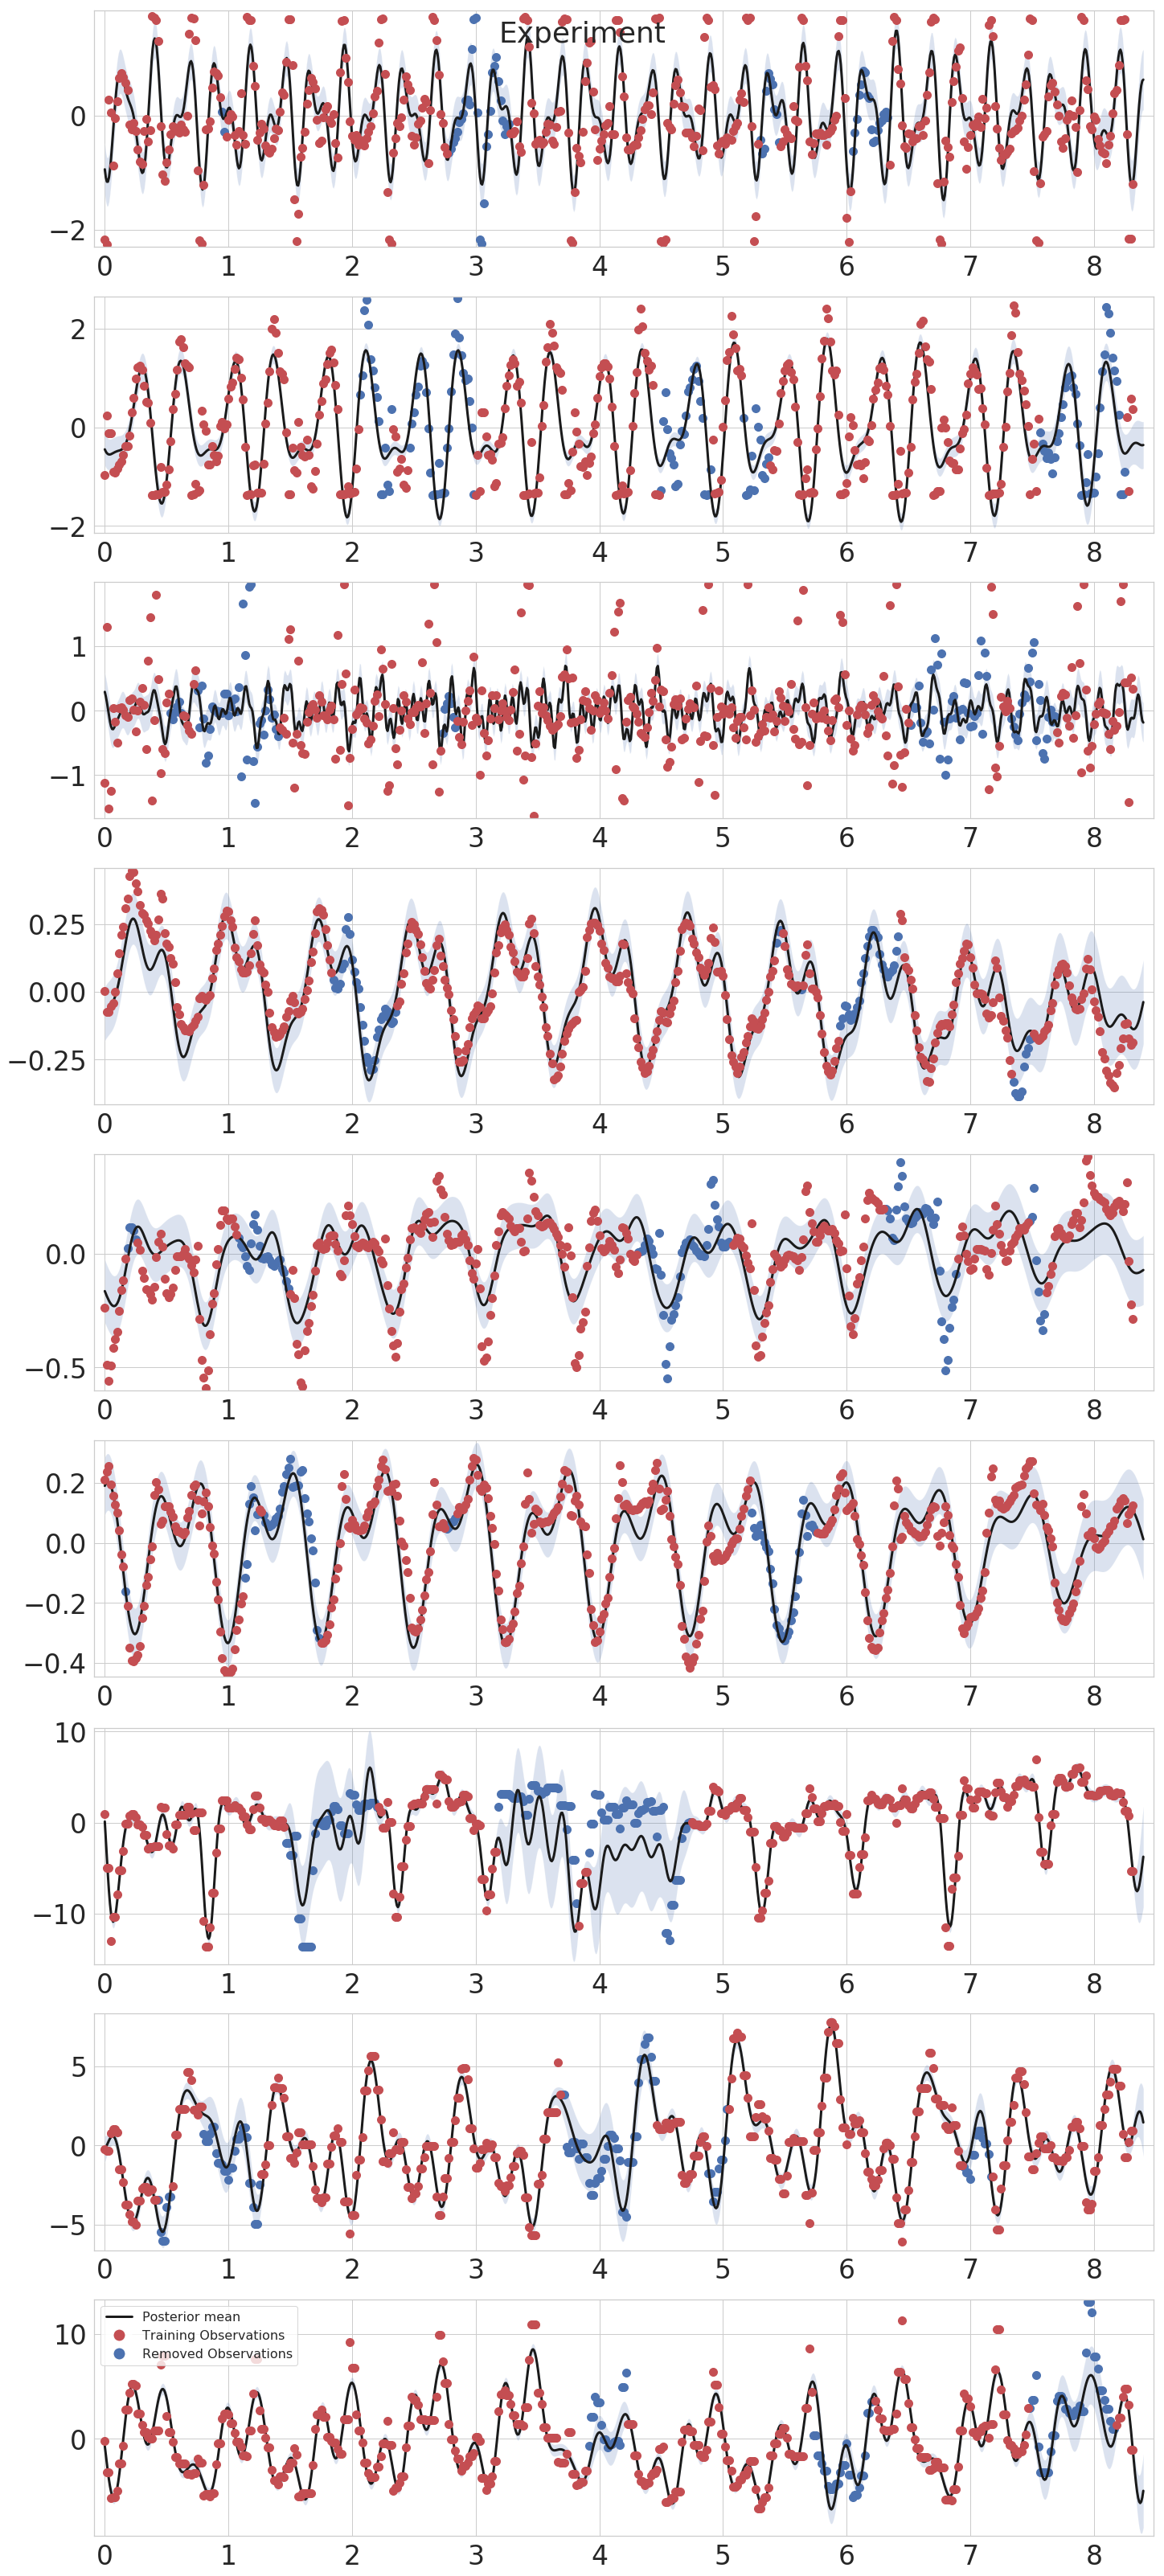

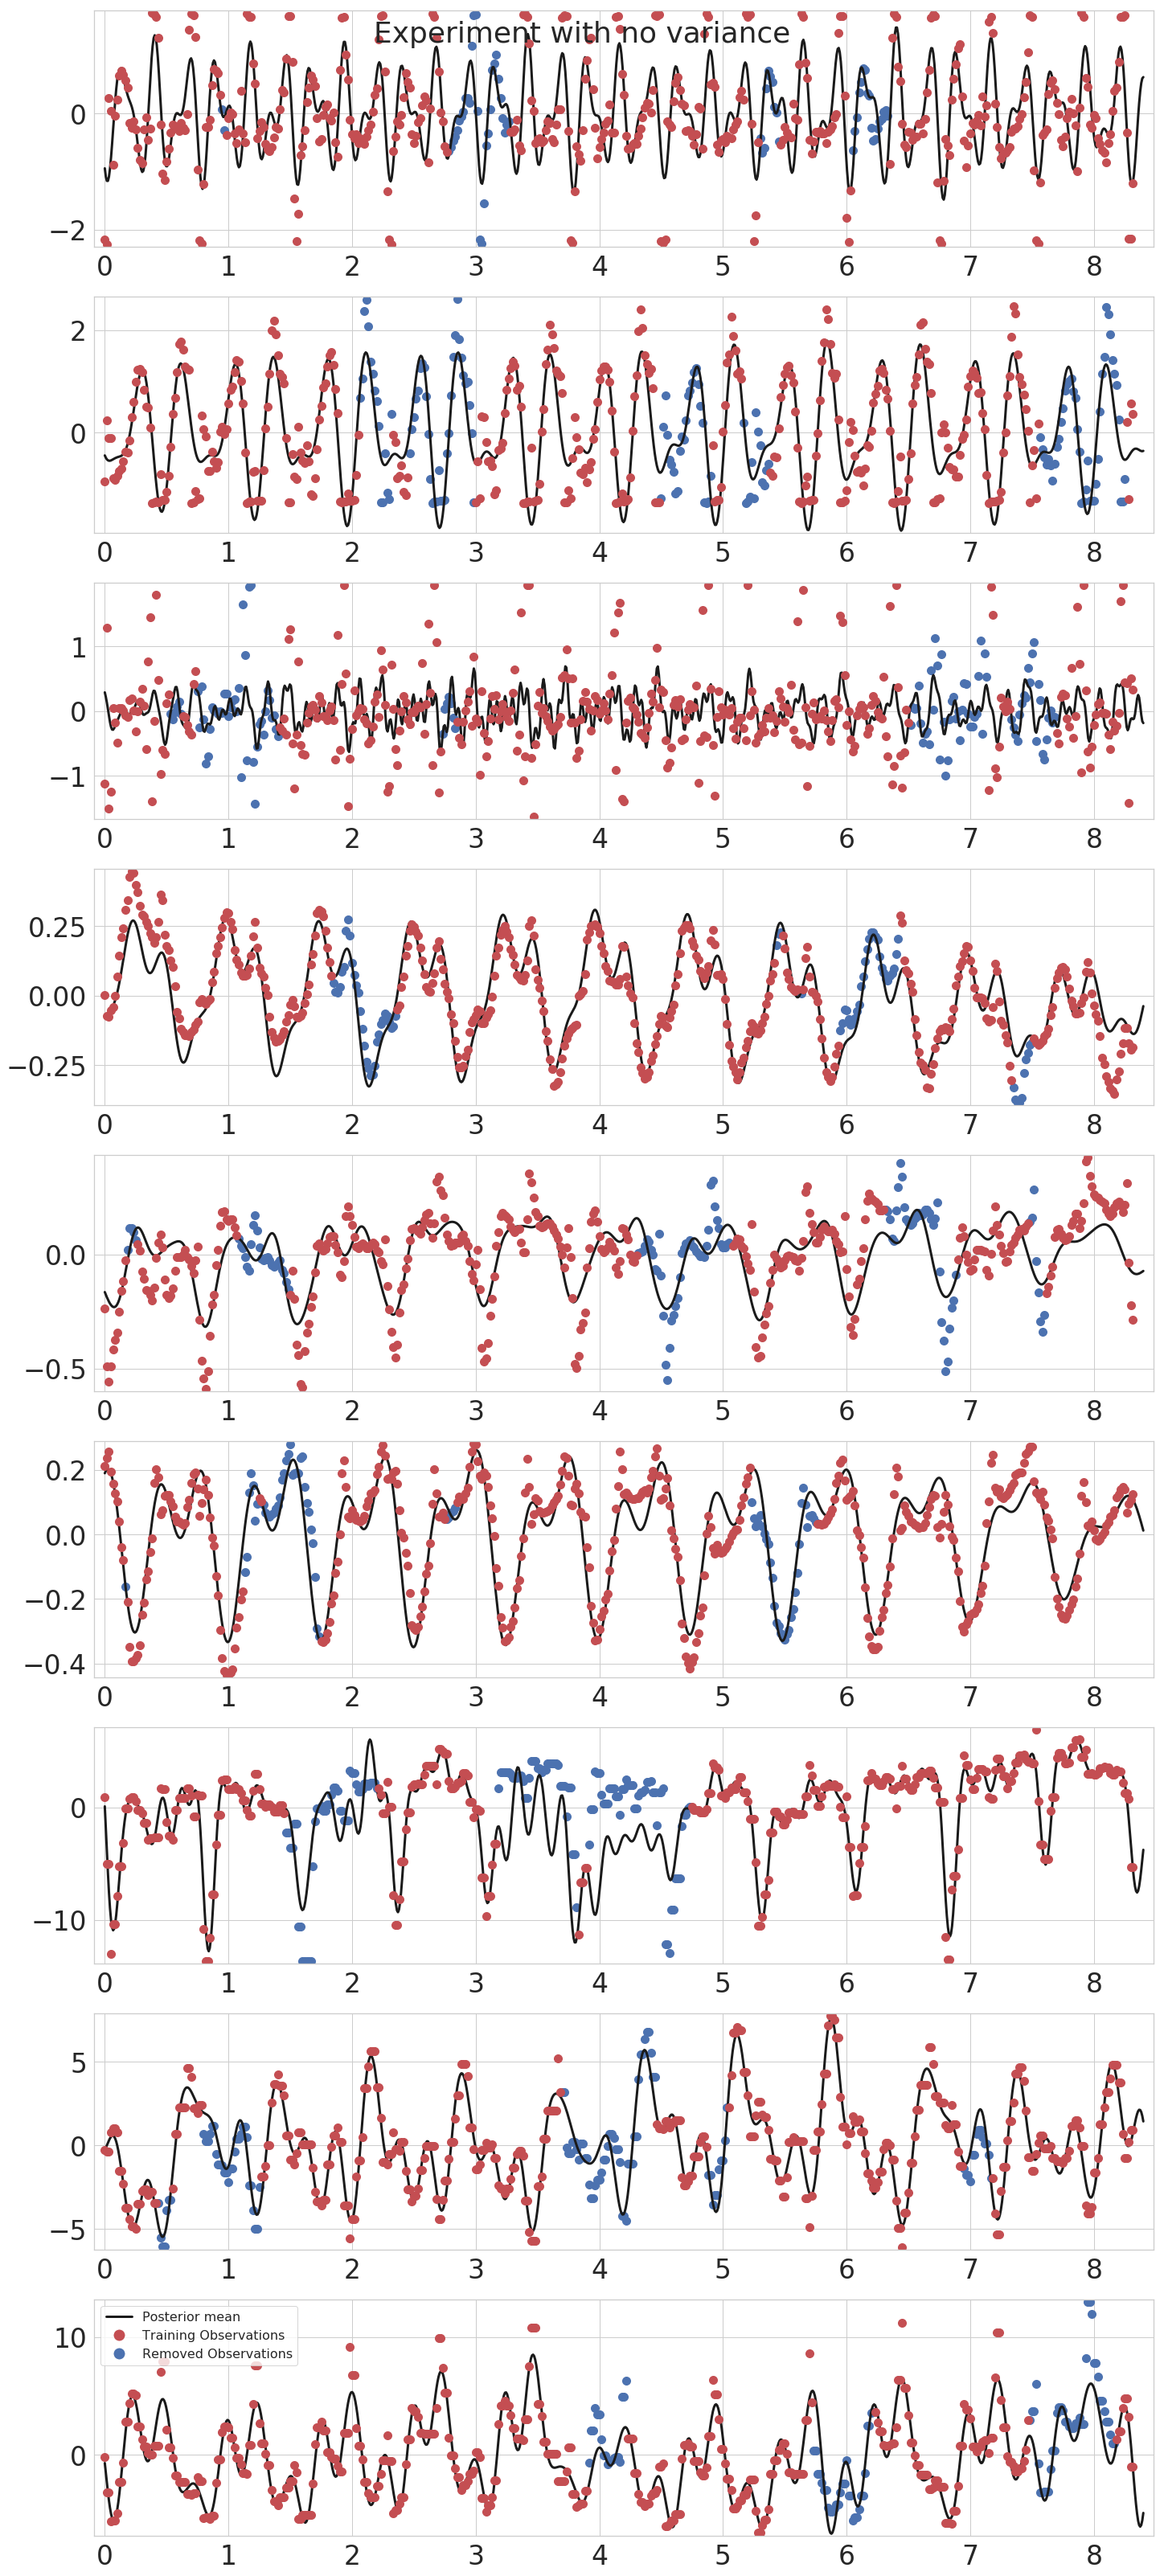

In [4]:
def make_X_y_from_measurements(measurement_list, no_of_channels):
    X_list = []
    y_list = []
    for index in range(no_of_channels):
        X_list.append(np.array([x/60 for x in range(500)]))
        y_list.append(measurement_list[:,index]-measurement_list[:,index].mean())
    return X_list, y_list

X_another_example, y_another_example = make_X_y_from_measurements(measurements[26], 9)

starting_time = time.time()
#We create the model, with 4 components and L-BFGS-B as the optimizer.
another_model = mogp_model(4, optimizer = 'L-BFGS-B')

X_another, y_another, X_deleted_another, y_deleted_another = another_model.remove_slabs(X_another_example, y_another_example)

X_input_another, Y_input_another = another_model.transform_lists_into_multioutput_format(X_another, y_another)

another_model.add_extra_observations(X_deleted_another, y_deleted_another, [i for i in range(number_of_channels)])

#We add the training data (in multi-output format) to the model.
another_model.add_training_data(X_input_another,Y_input_another)

X_pred_new = another_model.predict_interval(1000, [x for x in range(number_of_channels)], start = [[0] for x in range(number_of_channels)],end = [[8.4] for x in range(number_of_channels)]) 

################## Build model and optimization #####################
#In the example notebook we showed that the model can be built with randomly chosen 
#starting parameters and then optimized to minimize NLL.
#In this case we will use one of the heuristics included in the toolbox.
#What this heuristic does, briefly, is:
#1) Find the most relevant frequencies in the training data using bayesian non-parametric spectral estimation.
#2) Use the found frequencies to build the model (all other parameters taken randomly, where appropriate).
#3) Optimize in cascading fashion, first optimizing variances and constants, then delays, phases and means, then delays variances and constants. 
#4) Finally there's a last round of optimization over all parameters.
another_model.optimization_heuristic_one()
#####################################################################

#Perform the prediction over the test data.
Y_pred, STD_pred = another_model.predict(X_pred_new)

#We can compute mean absolute error over some data. Note that, in this example,
#we'll be computing over all the original data points, which includes the removed
#observations not used to optimize the model.
mae = another_model.compute_mae(X_list_climb, y_list_climb)
print("MAE over original data = ", mae)

#We inspect model parameters, after they have been optimized.
another_model.anchor_model()
print(another_model.read_trainables())

#We print the results of the prediction with and without variance.
another_model.make_plots("another_sample.png", var=True) #Variance is included in the plot.
another_model.make_plots("another_sample_no_var.png", var=False, title='Experiment with no variance') #Variance is not included.
#We can save the optimized model to memory.
another_model.save("smartphone_model_optimized_2")
end_time = time.time()
print("Total time for another sample: ", end_time-starting_time)